<a href="https://colab.research.google.com/github/life-ofpi/TansoZero-Data/blob/main/%ED%83%84%EC%86%8C_%ED%9A%8C%ED%94%BC%EB%9F%89_predict_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

base_path = "/content/drive/MyDrive/2025_SI/project"
df_contracts = pd.read_excel(f"{base_path}/신재생에너지 계약 현황 목록.xlsx")
df_generation = pd.read_excel(f"{base_path}/지역별 신재생 에너지 발전량.xlsx")
df_consumption = pd.read_csv(f"{base_path}/연도별 지역별 전력 사용량.csv", encoding='utf-8')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_contracts.columns = df_contracts.iloc[0]
df_contracts = df_contracts.drop(0)

replace_dict = {
    '강원특별자치도': '강원',
    '경기도': '경기',
    '경상북도': '경북',
    '경상남도': '경남',
    '전라북도': '전북',
    '전라남도': '전남',
    '전북특별자치도': '전북',
    '충청북도': '충북',
    '충청남도': '충남',
    '제주특별자치도': '제주',
    '서울특별시': '서울',
    '부산광역시': '부산',
    '대구광역시': '대구',
    '인천광역시': '인천',
    '광주광역시': '광주',
    '대전광역시': '대전',
    '울산광역시': '울산',
    '세종특별자치시': '세종'
}

df_contracts['시도구분'] = df_contracts['지역구분'].replace(replace_dict)
df_consumption['광역지자체']=df_consumption['광역지자체'].replace(replace_dict)


In [ ]:
df_contracts .head()

,발전원,지역구분,시도구분,개수,용량,지역개수,지역용량,연도
1,태양광,강원특별자치도,강원,120,10046.06,1420,"163,529.16",2024
2,태양광,강원특별자치도,강원,116,11968.6,1420,"163,529.16",2024
3,태양광,강원특별자치도,강원,10,572.25,1420,"163,529.16",2024
4,태양광,강원특별자치도,강원,34,10617.11,1420,"163,529.16",2024
5,태양광,강원특별자치도,강원,10,619.97,1420,"163,529.16",2024


In [ ]:
#계약량 전처리
df_contracts = df_contracts.rename(columns={
    '시도구분': '광역지자체',
    '지역용량': '계약용량(kW)'
})
df_contracts = df_contracts[['광역지자체', '연도', '계약용량(kW)']]
df_contracts['계약용량(kW)'] = df_contracts['계약용량(kW)'].astype(str).str.replace(',', '')
df_contracts['계약용량(kW)'] = pd.to_numeric(df_contracts['계약용량(kW)'], errors='coerce')
df_contracts['연도'] = pd.to_numeric(df_contracts['연도'], errors='coerce')
df_contracts = df_contracts.dropna(subset=['계약용량(kW)', '연도'])
df_contracts = df_contracts.drop_duplicates(subset=['광역지자체', '연도'])

# 발전량 전처리
df_generation = df_generation.rename(columns={'신재생에너지 합계': '발전량(MWh)'})
df_generation = df_generation[['연도', '광역지자체', '발전량(MWh)']]

# 소비량(사용량) 전처리
df_consumption = df_consumption.rename(columns={'총합': '전력소비량(MWh)'})
df_consumption = df_consumption[['연도', '광역지자체', '전력소비량(MWh)']]
#단위 보정 (MWh로 변환)
df_consumption['전력소비량(MWh)'] = df_consumption['전력소비량(MWh)'] / 1000


In [ ]:
def simplify_region(region):
    if pd.isna(region): return None
    region = str(region)
    for key in ["서울", "부산", "대구", "인천", "광주", "대전", "울산", "세종",
                "경기", "강원", "충북", "충남", "전북", "전남", "경북", "경남", "제주"]:
        if key in region:
            return key
    return region

#지역명 통일(혹시모르니까 한번 더)
df_contracts['지역'] = df_contracts['광역지자체'].apply(simplify_region)
df_generation['지역'] = df_generation['광역지자체'].apply(simplify_region)
df_consumption['지역'] = df_consumption['광역지자체'].apply(simplify_region)

# 최종 테이블 정리
df_contracts_final = df_contracts[['연도', '지역', '계약용량(kW)']]
df_generation_final = df_generation[['연도', '지역', '발전량(MWh)']]
df_consumption_final = df_consumption[['연도', '지역', '전력소비량(MWh)']]

# 병합
df_merged = df_contracts_final.merge(df_generation_final, on=['연도', '지역'], how='inner')
df_merged = df_merged.merge(df_consumption_final, on=['연도', '지역'], how='inner')

# 자립도 및 탄소회피량 계산
df_merged['자립도'] = df_merged['발전량(MWh)'] / df_merged['전력소비량(MWh)']
df_merged['탄소회피량(tCO2)'] = df_merged['발전량(MWh)'] * 0.4781
#발전량 * 전력생상 1MWh당 회피 가능한 탄소 배출량(최근 기준)
#df_merge확인해보면 발전량은 다른 data랑 달리 2012년부터 있기때문에 nan이 많음. 일단 제거

In [ ]:
df_merged.tail(5)

,연도,지역,계약용량(kW),발전량(MWh),전력소비량(MWh),자립도,탄소회피량(tCO2)
44,2021,전남,363064.93,6158271,3.348689e+07,0.183901,2.944269e+06
45,2021,전북,456449.20,8325469,2.148686e+07,0.387468,3.980407e+06
46,2021,제주,45307.21,2662500,5.687730e+06,0.468113,1.272941e+06
47,2021,충남,272245.10,8489538,4.880163e+07,0.173960,4.058848e+06
48,2021,충북,138272.89,2225401,2.840206e+07,0.078353,1.063964e+06


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 1.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1uu5d_bd/i4k30sqd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1uu5d_bd/key0qciv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6819', 'data', 'file=/tmp/tmp1uu5d_bd/i4k30sqd.json', 'init=/tmp/tmp1uu5d_bd/key0qciv.json', 'output', 'file=/tmp/tmp1uu5d_bd/prophet_modelu4g41077/prophet_model-20250522081714.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
08:17:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:17:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cm

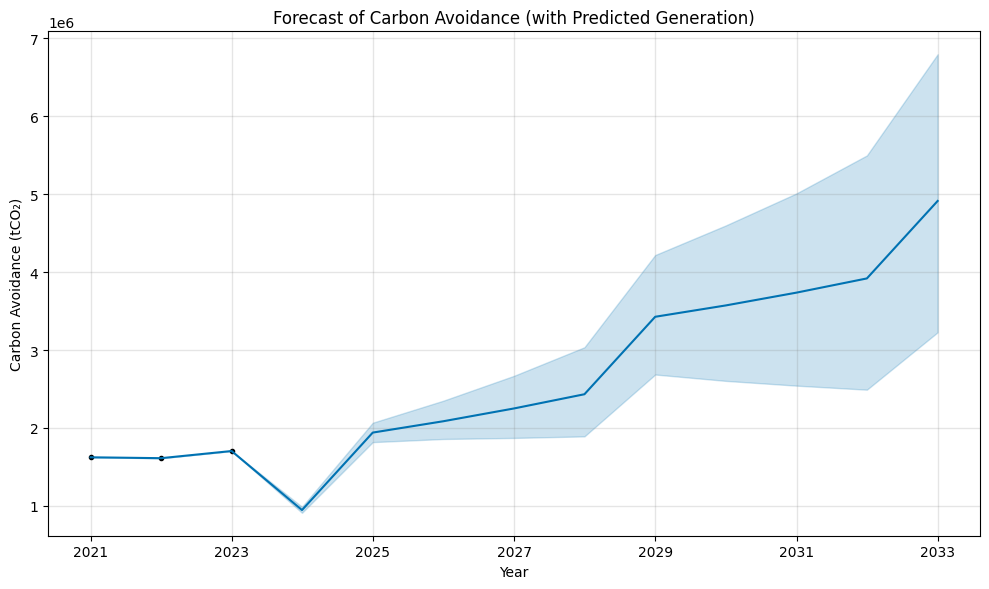

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet

#1.결측치 제거
df_model = df_merged.dropna(subset=['계약용량(kW)', '발전량(MWh)', '전력소비량(MWh)', '자립도'])

#2.발전량 예측 모델 학습
X = df_model[['계약용량(kW)', '전력소비량(MWh)', '자립도']]
y = df_model['발전량(MWh)']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
reg = LinearRegression()
reg.fit(X_train, y_train)

#3.예측된 발전량으로 탄소회피량 공식 계산
df_model['예측_발전량(MWh)'] = reg.predict(X)
carbon_emission_factor = 0.4781
df_model['예측_탄소회피량(tCO2)'] = df_model['예측_발전량(MWh)'] * carbon_emission_factor

#4.연도별 평균값 생성
df_avg = df_model.groupby('연도')[['계약용량(kW)', '전력소비량(MWh)', '자립도', '예측_발전량(MWh)', '예측_탄소회피량(tCO2)']].mean().reset_index()
df_avg['ds'] = pd.to_datetime(df_avg['연도'], format='%Y')
df_avg = df_avg.drop(columns=['연도'])

#5.Prophet 시계열 예측 (예측된 탄소회피량 기준)
df_prophet = df_avg[['ds', '예측_탄소회피량(tCO2)']].rename(columns={'예측_탄소회피량(tCO2)': 'y'})
model = Prophet()
model.fit(df_prophet)
future = model.make_future_dataframe(periods=10, freq='Y')
forecast = model.predict(future)

#6.시각화
model.plot(forecast)
plt.title("Forecast of Carbon Avoidance (with Predicted Generation)")
plt.xlabel("Year")
plt.ylabel("Carbon Avoidance (tCO₂)")
plt.tight_layout()
plt.show()


In [ ]:
forecast['연도'] = forecast['ds'].dt.year
# 연도별 yhat 평균 계산
yearly_avg = forecast.groupby('연도')[['yhat', 'yhat_lower', 'yhat_upper']].mean().round(2)
yearly_avg
#yhat	예측된 탄소회피량
#yhat_lower	예측 하한값 (신뢰구간 80~90%)
#yhat_upper	예측 상한값

,yhat,yhat_lower,yhat_upper
연도,,,
2021,1624062.04,1624062.04,1624062.04
2022,1612655.04,1612655.04,1612655.04
2023,1325799.58,1308182.66,1346856.28
2024,1941172.03,1818771.26,2067823.29
2025,2086644.77,1858995.83,2350265.21
2026,2250565.44,1872575.14,2668929.10
2027,2433173.22,1892353.11,3035985.75
2028,3427227.76,2686251.27,4219451.78
2029,3572700.51,2604725.04,4599187.69


▶️ 전반적인 예측 추세
2024년 일시 하락 후, 2025년부터 탄소회피량이 지속적으로 증가하는 예측

2033년까지 탄소회피량이 500만 tCO₂를 넘는 수준으로 상승함



In [ ]:
#RandomForest로도 해보기
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

X = df_model[['계약용량(kW)', '전력소비량(MWh)', '자립도']]
y = df_model['발전량(MWh)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 모델 교체
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# 성능 확인
print("R²:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))

df_model['예측_발전량(MWh)'] = model.predict(X)
df_model['예측_탄소회피량(tCO2)'] = df_model['예측_발전량(MWh)'] * 0.4781
#R² (결정계수): 0.9185 < 우수한 예측력


R²: 0.9185043222170121
MSE: 553088146000.3342
